In [74]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_squared_error

In [113]:
df = web.DataReader('TSLA', data_source='yahoo', start='2010-01-01', end='2020-12-17')
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2638.000000,2638.000000,2638.000000,2638.000000,2.638000e+03,2638.000000
mean,60.011504,57.345643,58.701021,58.771817,3.167923e+07,58.771817
std,88.748010,83.791178,86.316936,86.637737,2.909014e+07,86.637737
min,3.326000,2.996000,3.228000,3.160000,5.925000e+05,3.160000
25%,7.589500,7.340500,7.400500,7.418000,1.111362e+07,7.418000
50%,45.108000,43.672001,44.410999,44.351000,2.482425e+07,44.351000
75%,61.532999,59.345000,60.406001,60.555500,4.105700e+07,60.555500
max,658.820007,623.799988,653.690002,655.900024,3.046940e+08,655.900024


In [114]:
# num of rows and columns
rows = df.shape[0]
cols = df.shape[1]
look_back = 100

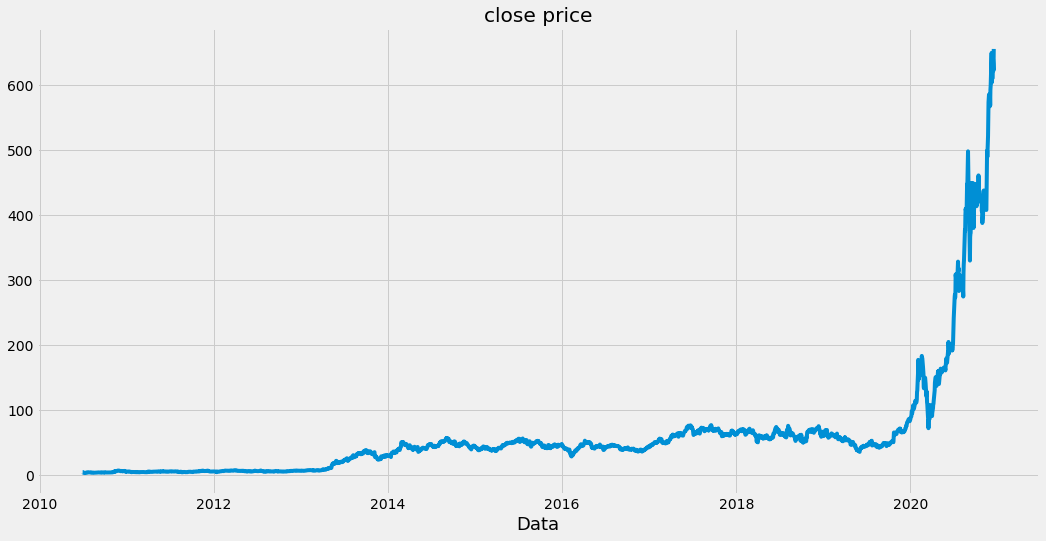

In [115]:
# Plot of Close Price
plt.figure(figsize=(16,8))
plt.title('close price')
plt.plot(df['Close'])
plt.xlabel('Data', fontsize=18)
plt.show()

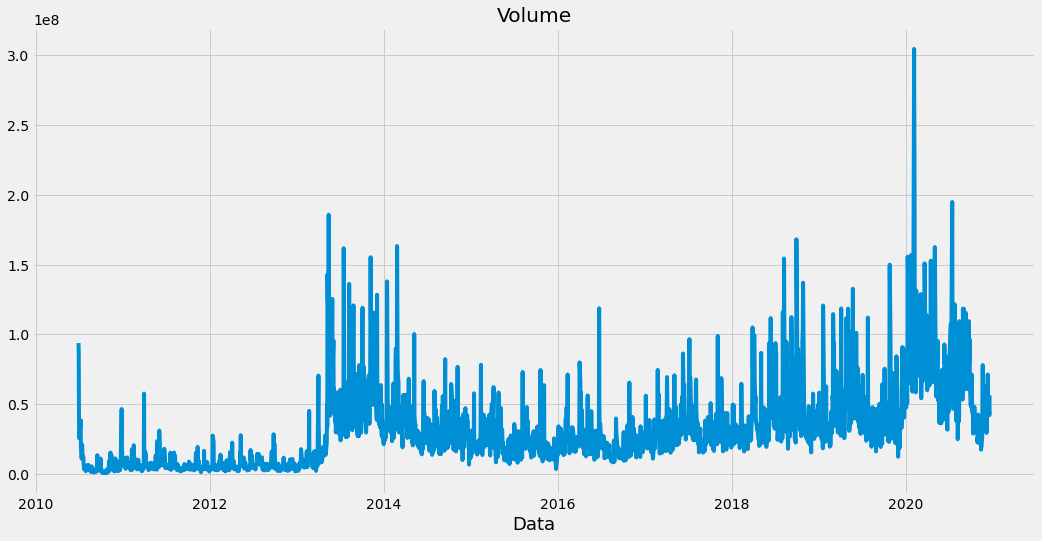

In [116]:
# Plot of Volume
plt.figure(figsize=(16,8))
plt.title('Volume')
plt.plot(df['Volume'])
plt.xlabel('Data', fontsize = 18)
plt.show()


In [117]:
data = df.filter(['Close'])
dataset = data.values
train_data_len = math.ceil( len(dataset)* .8)


In [118]:
# scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00247878],
       [0.0024604 ],
       [0.00188743],
       ...,
       [0.96530008],
       [0.94924472],
       [1.        ]])

In [119]:
# preparing the data
train_data = scaled_data[0:train_data_len, :]
x_train = []
y_train = []

for i in range(100, len(train_data)):
  x_train.append(train_data[i-look_back:i, 0])
  y_train.append(train_data[i,0])



In [120]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [121]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], look_back, 1))
x_train.shape

(2011, 100, 1)

In [122]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))



In [123]:
model.compile(optimizer='adam', loss='mean_squared_error')


Epoch 1/4
2011/2011 [==============================] - 18s 8ms/step - loss: 1.2296e-04
Epoch 2/4
2011/2011 [==============================] - 17s 8ms/step - loss: 2.6131e-05
Epoch 3/4
2011/2011 [==============================] - 17s 8ms/step - loss: 1.8069e-05
Epoch 4/4
2011/2011 [==============================] - 17s 8ms/step - loss: 1.1399e-05


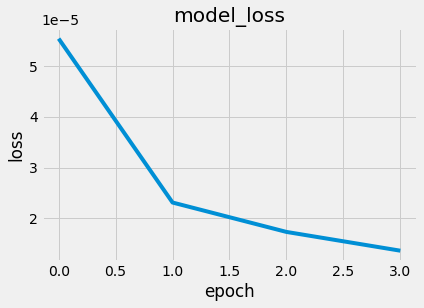

In [124]:
#Training
history = model.fit(x_train, y_train, batch_size=1, epochs=4)
plt.plot(history.history['loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [125]:
# testing dataset
test_data = scaled_data[train_data_len - look_back:, :]
x_test = []
y_test = dataset[train_data_len:, :]
for i in range(look_back, len(test_data)):
  x_test.append(test_data[i- look_back:i,0])


In [126]:
x_test = np.array(x_test)

In [127]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))


In [128]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


In [129]:
#rmse = np.sqrt(((predictions - y_test)**2).mean())
rmse = (np.sqrt(np.mean(np.square((y_test - predictions)/ y_test))))*100
rmse
test_score = np.sqrt(mean_squared_error(y_test, predictions))
test_score

16.519282825477166

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


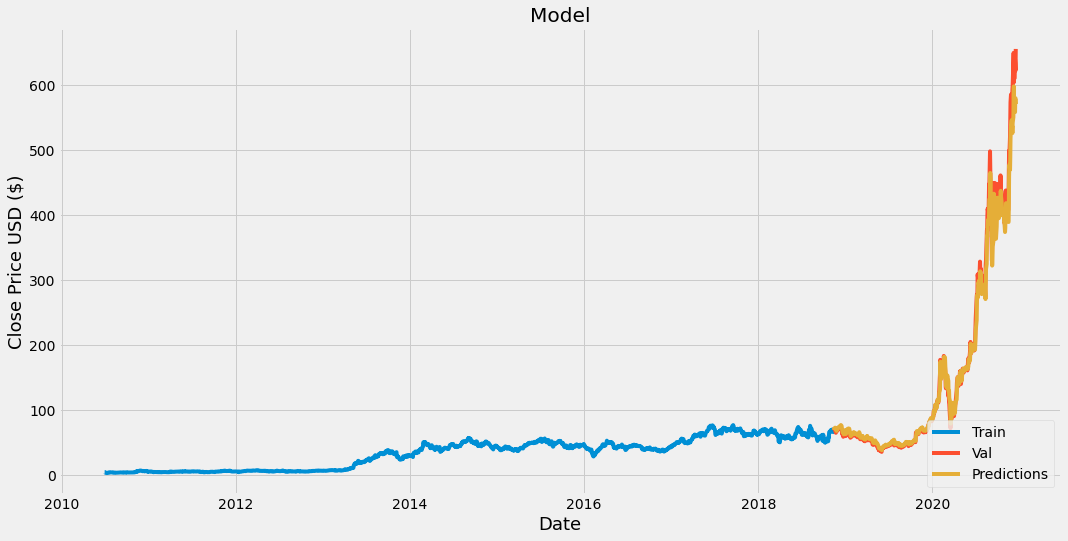

In [130]:
train = data[:train_data_len]
valid = data[train_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize = (16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')